In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## Defining the csv file
file_key = 'turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## 1. Using the pandas library to read the csv data file and create a data-frame called turnover

turnover = pd.read_csv(file_content_stream)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
## 2. Changing sales and salary from labels to dummy variables

## sales variable
turnover = pd.concat([turnover.drop(columns = ['sales']), pd.get_dummies(turnover['sales'])], axis = 1)

## salary variable
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0


[Text(558.0, 856.1700000000001, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(279.0, 611.55, 'number_project <= 2.5\ngini = 0.479\nsamples = 3359\nvalue = [1335, 2024]'),
 Text(139.5, 366.93000000000006, 'last_evaluation <= 0.575\ngini = 0.219\nsamples = 1399\nvalue = [175, 1224]'),
 Text(69.75, 122.30999999999995, 'gini = 0.104\nsamples = 1290\nvalue = [71, 1219]'),
 Text(209.25, 122.30999999999995, 'gini = 0.088\nsamples = 109\nvalue = [104, 5]'),
 Text(418.5, 366.93000000000006, 'satisfaction_level <= 0.115\ngini = 0.483\nsamples = 1960\nvalue = [1160, 800]'),
 Text(348.75, 122.30999999999995, 'gini = 0.0\nsamples = 706\nvalue = [0, 706]'),
 Text(488.25, 122.30999999999995, 'gini = 0.139\nsamples = 1254\nvalue = [1160, 94]'),
 Text(837.0, 611.55, 'time_spend_company <= 4.5\ngini = 0.174\nsamples = 8640\nvalue = [7807, 833]'),
 Text(697.5, 366.93000000000006, 'average_montly_hours <= 290.5\ngini = 0.029\nsamples = 7085\nvalue = [6981, 104]

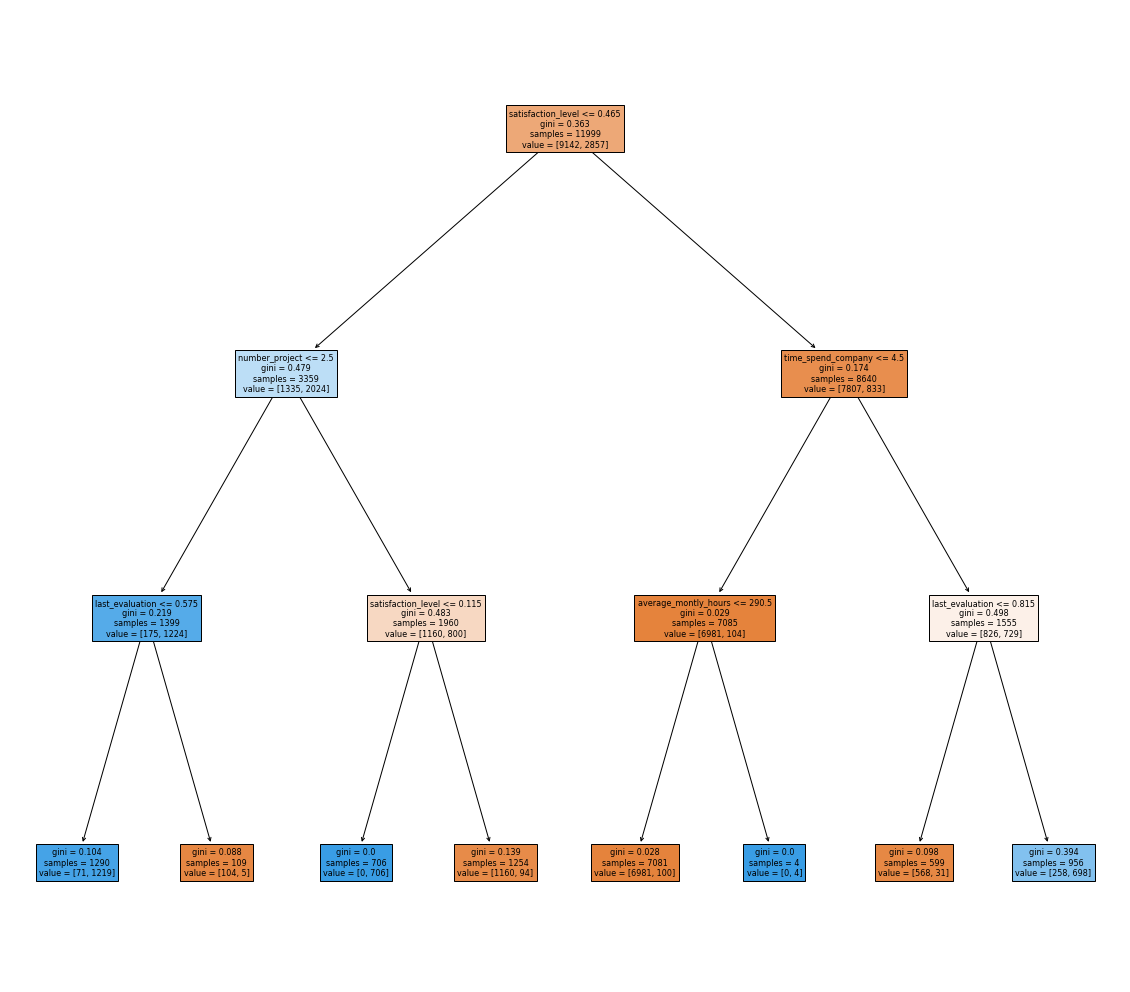

In [7]:
## 3. Using satisfaction level, last evaluation, number project, average montly hours, time spend company, Work accident, 
## promotion last 5years, sales (dummy variables), and salary (dummy variables) as the input variables and left as the 
## target variable

## Defining the input and target variables
X = turnover.drop(columns = ['left', 'salary'])
Y = turnover['left']

## i) Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)


## ii) Building a decision tree model with max depth = 3 on the train data-frame
md1 = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 18))
plot_tree(md1, feature_names = X_train.columns, filled = True)

In [9]:
## Creating new features:

turnover['Interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & 
                                     (turnover['last_evaluation'] <= 0.575), 1, 0)

turnover['Interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] > 2.5) & 
                                     (turnover['satisfaction_level'] <= 0.115), 1, 0)

turnover['Interaction_3'] = np.where((turnover['satisfaction_level'] > 0.465) & (turnover['time_spend_company'] <= 4.5) & 
                                     (turnover['average_montly_hours'] <= 290.5), 1, 0)

In [10]:
## 4. Using satisfaction level, last evaluation, number project, average montly hours, time spend company, 
## Work accident, promotion last 5years, sales (dummy variables), and salary (dummy variables) and interactions/
## features (from part 3) as the input variables and left as the target variable to split the data 

## Defining the input and target variables
X = turnover.drop(columns = ['left', 'salary'])
Y = turnover['left']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [12]:
## 5. Using train data-frame to build a random forest model (with 500 trees and the maximum depth of each tree equal 
## to 3)

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2286
           1       0.89      0.91      0.90       714

    accuracy                           0.95      3000
   macro avg       0.93      0.94      0.93      3000
weighted avg       0.95      0.95      0.95      3000



In [13]:
## 6. Using train (without the interaction features) data-frame build a random forest model (with 500 trees and the 
## maximum depth of each tree equal to 3)

X_train = X_train.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3'])
X_test = X_test.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3'])

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2286
           1       0.73      0.87      0.80       714

    accuracy                           0.89      3000
   macro avg       0.84      0.89      0.86      3000
weighted avg       0.90      0.89      0.90      3000



In [ ]:
## 7. Using the results from part 6 and 7, we would use the Random Forest Classifier model with the
## interaction variables to predict left (much better accuracy and recall scores)